# Data import

In [2]:
import pandas as pd
import os

DATA_FOLDER = './data_v2'
DATA_FILES = [os.path.join(DATA_FOLDER, file) for file in  os.listdir(DATA_FOLDER)]

datasets = {data: pd.read_json(data, lines=True) for data in DATA_FILES}

# Dataset analysys

## Null values

In [3]:
for dataset_name, dataset in datasets.items():
  null_dict = dataset.isnull().sum()
  print(f"DATASET {dataset_name}: ")
  print('---------------------------')
  for key, val in null_dict.items():
    print(f"{key:<15}: {val:<10}")
  print('===========================')
    

DATASET ./data_v2\artists.jsonl: 
---------------------------
id             : 0         
name           : 0         
genres         : 0         
DATASET ./data_v2\sessions.jsonl: 
---------------------------
timestamp      : 0         
user_id        : 0         
track_id       : 0         
event_type     : 0         
session_id     : 0         
DATASET ./data_v2\tracks.jsonl: 
---------------------------
id             : 0         
name           : 0         
popularity     : 0         
duration_ms    : 0         
explicit       : 0         
id_artist      : 0         
release_date   : 0         
danceability   : 0         
energy         : 0         
key            : 0         
mode           : 103719    
loudness       : 0         
speechiness    : 0         
acousticness   : 0         
instrumentalness: 0         
liveness       : 0         
valence        : 0         
tempo          : 0         
time_signature : 0         
DATASET ./data_v2\track_storage.jsonl: 
-----------------

## IDS = -1

In [4]:
for dataset_name, dataset in datasets.items():
  id_candidates = [key for key in dataset.keys() if 'id' in key]
  negative_ids = 0
  for id_candidate in id_candidates:
    negative_ids += len(dataset[dataset[id_candidate] == -1])
  print(f"DATASET {dataset_name}: ")
  print('---------------------------')
  print(f"Negative id\'s: {negative_ids:<10}")
  print('===========================')

DATASET ./data_v2\artists.jsonl: 
---------------------------
Negative id's: 0         
DATASET ./data_v2\sessions.jsonl: 
---------------------------
Negative id's: 0         
DATASET ./data_v2\tracks.jsonl: 
---------------------------
Negative id's: 0         
DATASET ./data_v2\track_storage.jsonl: 
---------------------------
Negative id's: 0         
DATASET ./data_v2\users.jsonl: 
---------------------------
Negative id's: 0         


## Wnioski

Wyraźnie widać, że wcześniejsze problemy z danymi już nie występują. Możemy zatem przejść do faktycznej analizy danych pod względem biznesowym

# Analiza danych

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
artists = pd.read_json("data_v2/artists.jsonl", lines=True)
sessions = pd.read_json("data_v2/sessions.jsonl", lines=True)
track_storage = pd.read_json("data_v2/track_storage.jsonl", lines=True)
tracks = pd.read_json("data_v2/tracks.jsonl", lines=True)
users = pd.read_json("data_v2/users.jsonl", lines=True)

pd.set_option('mode.chained_assignment', None)

### Session event types

In [7]:
sessions['event_type'].unique()

array(['PLAY', 'SKIP', 'ADVERTISEMENT', 'LIKE', 'BUY_PREMIUM'],
      dtype=object)

### Interesujące dla nas mogą być zdarzenia: 'PLAY' i 'SKIP'

Na ich podstawie możemy szacować czas słuchania wykonawcy muzycznego przez użytkowników. Zakładając, że zdarzenie PLAY oznacza średnio przesłuchanie całego utworu, a SKIP oznacza pominięcie średnio połowy długości utworu, możemy spróbować przedstawić średni czas słuchania wykonawcy w następujący sposób.

Timestamps

In [8]:
print(f"Min: {sessions['timestamp'].min()} - Max: {sessions['timestamp'].max()}")
print(f"Period: {sessions['timestamp'].max() - sessions['timestamp'].min()}")

Min: 2023-01-09 07:53:36.153061 - Max: 2023-04-10 01:55:04.620441
Period: 90 days 18:01:28.467380


Mamy do czynienia z danymi z przedziału 4 miesięcy - od 9.01 do 10.04

Połączenie danych z utworami i artystami + segregacja po tygodniu wydarzenia

In [9]:
def get_week(date):
  return date.week

merged = sessions.merge(tracks[['id', 'id_artist', 'duration_ms']], left_on='track_id', right_on='id', how='left')
merged = merged.merge(artists[['id', 'name']], left_on='id_artist', right_on='id', how='left')

# This will be removed in actual analysis
sessions_merged = merged[merged['timestamp'] < '2023-04-10']

sessions_merged['weeks_ordered'] = sessions_merged['timestamp'].apply(get_week)

In [10]:
max_week = sessions_merged['weeks_ordered'].max()
min_week = sessions_merged['weeks_ordered'].min()

print(f"Min: {min_week}, Max: {max_week}")

Min: 2, Max: 14


## Wykresy akcji związanych z utworami w okresach

C:\Users\User\AppData\Local\Temp/ipykernel_22968/3968470964.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(sessions_merged[sessions['event_type'] == key].groupby('weeks_ordered').size(), label=key, marker='o')


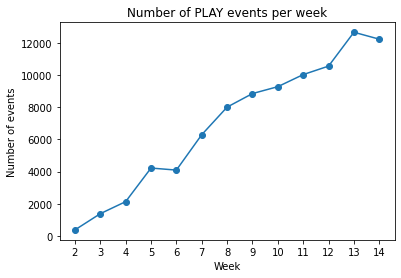

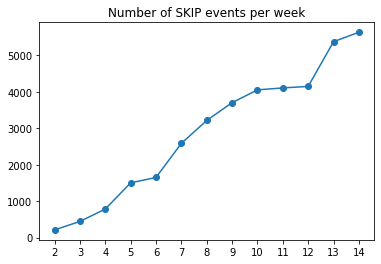

In [11]:
plt.xlabel("Week")
plt.ylabel("Number of events")
for key in ['PLAY', 'SKIP']:
    plt.title(f"Number of {key} events per week")
    plt.plot(sessions_merged[sessions['event_type'] == key].groupby('weeks_ordered').size(), label=key, marker='o')
    plt.xticks(range(min_week, max_week + 1, 1))
    plt.show()


### Problemem może być niespójność, możemy przewidywać rokowania artystów, których utwory były słuchane w każdym z okresów

In [12]:
all_artists = sessions_merged['name'].unique()
print(len(all_artists))

808


In [13]:
consistent_artists = []

for artist in all_artists:
    if len(sessions_merged[sessions_merged['name'] == artist]['weeks_ordered'].unique()) == 12:
        consistent_artists.append(artist)

print(len(consistent_artists))

199


Mamy zaledwie 199 spośród 808 artystów, którzy byli słuchani w każdym okresie i jesteśmy dla nich w stanie przewidzieć rokowania za pomocą proponowanego rozwiązania.

In [14]:
def approximate_playtime(artist_sessions):
    play_playtime = artist_sessions[artist_sessions['event_type'] == 'PLAY'].groupby('weeks_ordered')['duration_ms'].sum() * 1.66e-5 # convert to minutes
    # skip_playtime = artist_sessions[artist_sessions['event_type'] == 'SKIP'].groupby('weeks_ordered')['duration_ms'].sum() / 2
    return play_playtime

def plot_actions(artists, sessions_merged):
    COLS = len(artists)
    fig, axs = plt.subplots(1, COLS, figsize=(20, 5))
    
    col = 0
    for artist in artists:
        artist_sessions = sessions_merged[sessions_merged['name'] == artist]
        approximated_playtime = approximate_playtime(artist_sessions)
        axs[col].set_xlabel("Week [ordered Number]")
        axs[col].set_ylabel("Play time [minutes]")
        axs[col].plot(approximated_playtime, label=artist, marker='o')
        axs[col].set_title(f"Artist: {artist}")
        axs[col].grid()
        col += 1


### Sort consistent artists by popularity

In [15]:
artists_dic = {}
for artist in consistent_artists:
  artists_dic[artist] = approximate_playtime(sessions_merged[sessions_merged['name'] == artist]).sum()

artists_dic = {k: v for k, v in sorted(artists_dic.items(), key=lambda item: item[1])}

## Popularni wykonawcy

In [16]:
print(list(artists_dic.keys())[-5:])

['Imagine Dragons', 'Lewis Capaldi', 'Taylor Swift', 'Glass Animals', 'Ed Sheeran']


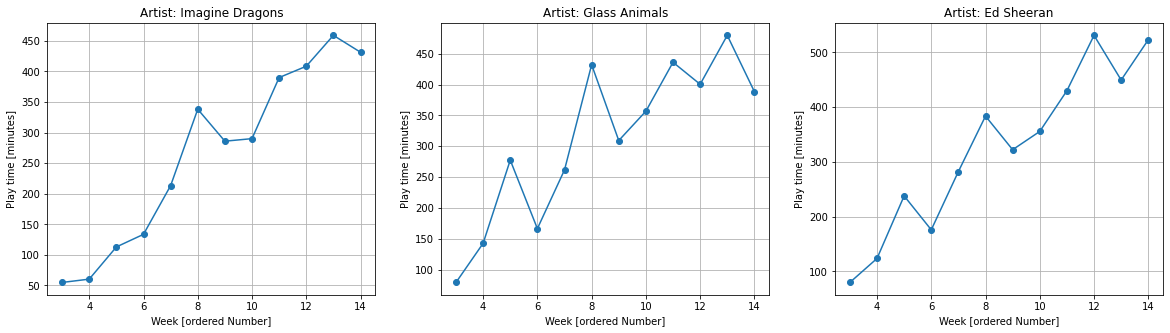

In [17]:
TARGET_ARTISTS = ["Imagine Dragons", "Glass Animals", "Ed Sheeran"]

plot_actions(TARGET_ARTISTS, sessions_merged)

## Mniej popularni

In [18]:
print(list(artists_dic.keys())[:5])

['Josh White', 'Supergrass', 'Leroy Carr', "Screamin' Jay Hawkins", 'The Kooks']


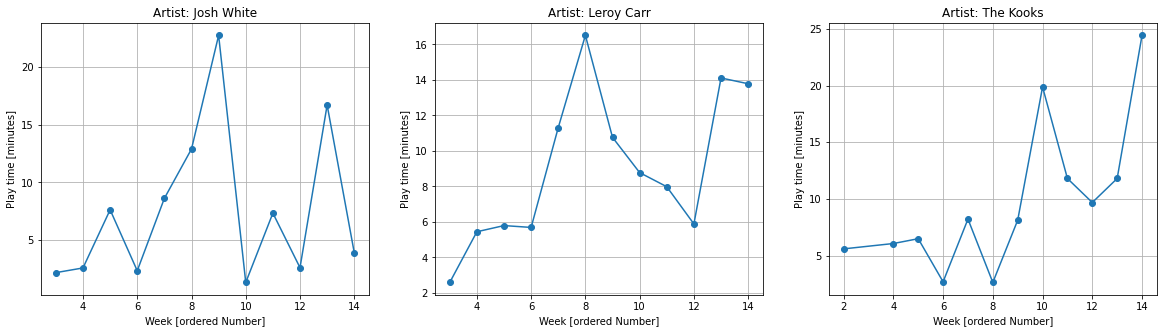

In [19]:
TARGET_ARTISTS = ["Josh White", "Leroy Carr", "The Kooks"]

plot_actions(TARGET_ARTISTS, sessions_merged)

### Inne przydatne kolumny

Warto wziąć pod uwagę niektóre z cech utorów takie jak długość utworu, jego popularność i explicit kontent, które mogą dodatkowo wpływać na ilość odtworzeń / ostateczne wynagrodzenie artysty.

### Popularity

In [20]:
print("Most popular:")
print(tracks.sort_values(by='popularity', ascending=False)[['name', 'popularity']].head(10))
print("=============================================")
print("Least popular:")
print(tracks.sort_values(by='popularity', ascending=True)[['name', 'popularity']].head(10))
print("=============================================")

Most popular:
                     name  popularity
58504     drivers license          99
124052          telepatía          97
23282           positions          92
8378                  911          91
128281  Someone You Loved          90
65890              Anyone          90
98264      Therefore I Am          90
15077             Whoopty          89
9467               Arcade          89
32754            Believer          88
Least popular:
                                            name  popularity
40921                            Rondine Al Nido           0
42636                                   Agg Lagi           0
62933                A Lo Gaucho - Remasterizado           0
42646                                 Mr. Dollar           0
42654                       Weeping Willow Blues           0
126875  Work My Beats 2010 - Original 2010 Remix           0
12220                     Kahe Ko Mohe Chhede Re           0
42656             Insomnia - Live in Krakow 2009           0
1156

# Wnioski końcowe

### Dane wejściowe i wyjściowe modelu

Na powyższych wykresach widać tendencje wzrostową / spadkową dla interakcji użytkowników z utowrami muzycznymi danych artystów. Po obrobieniu danych nasz model będzie przyjmować na wejście sekwencję reprezentującą łączny czas słuchania wykonawcy w kolejnych interwałach czasowych i na tej podstawie przewidywać średni czas słuchania wykonawcy w następnym interwale (przyszłości).